## I had already collected and formatted the data. More details in "data_collection.ipynb" and "data_with_sentiment.ipynb" file.

In [66]:
import pandas as pd

dataset i have created earlier had to preprocess to train the model.

In [67]:
btc = pd.read_csv("merged_data.csv")

In [68]:
# Converting the 'timestamp' column to datetime
btc['timestamp'] = pd.to_datetime(btc['timestamp'])

# Setting the 'timestamp' column as the index. its better for the working purpose as it is time series, so serial and date matters.
btc.set_index('timestamp', inplace=True)

merged_comments and target is not necessary. As I already have the sentiment score.

In [69]:
del btc["merged_comments"]
del btc["target"]

In [70]:
btc = btc.dropna()
btc

,open,high,low,close,volume,comment_count,sentiment_score
timestamp,,,,,,,
2020-01-22 07:00:00,8753.66,8818.00,8706.07,8740.27,2896.788689,1.0,0.0
2020-01-22 08:00:00,8740.49,8746.34,8656.00,8678.69,3374.764471,0.0,0.0
2020-01-22 09:00:00,8678.67,8688.99,8643.31,8686.28,1638.063198,0.0,0.0
2020-01-22 10:00:00,8684.56,8686.68,8651.00,8663.36,1303.479686,0.0,0.0
2020-01-22 11:00:00,8662.90,8670.49,8622.00,8659.87,1708.384236,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-31 20:00:00,42619.04,42680.36,42504.56,42558.01,1015.140350,0.0,0.0
2023-12-31 21:00:00,42558.02,42670.44,42520.72,42520.72,923.438130,0.0,0.0
2023-12-31 22:00:00,42520.73,42591.10,42056.00,42257.88,1811.594110,0.0,0.0


<Axes: xlabel='timestamp'>

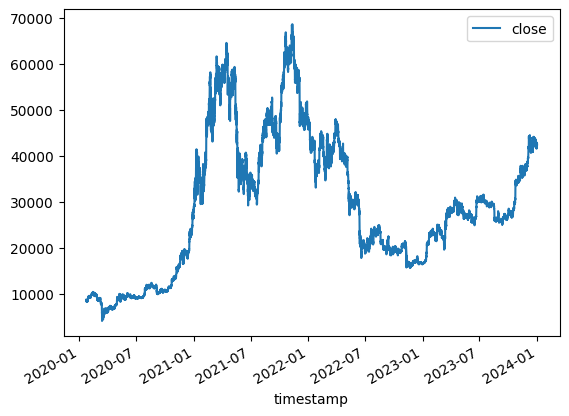

In [71]:
btc.plot.line(y="close", use_index=True)

In [72]:
btc["predict"] = btc["close"].shift(-1)

creating the target columns for the model

In [73]:
btc["target"] = (btc["predict"] > btc["close"]).astype(int)


To check that we got balanced dataset

In [74]:
btc["target"].value_counts()

target
1    17542
0    16980
Name: count, dtype: int64

saving the dataset

In [75]:
btc.to_csv("btc_data.csv")

checking if the model is working properly

In [76]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=42)


train = btc.iloc[:-200]
test = btc[-200:]

predictors = ["close", "volume", "open", "high", "low", "comment_count","sentiment_score"]
model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=50, random_state=42)

the prediction is not good, we see only around 50% was correct from the test set. I will try to train a better model. Please check model.ipynb 

In [86]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target"], preds)

0.5789473684210527

# Backtesting, mantaining the time series and predict fututre

In [92]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.DataFrame(preds, index=test.index, columns=["predictions"])
    return pd.concat([test["target"], preds], axis=1)

In [93]:
def backtest(data, model, predictors, start=1095, step=150):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


In [94]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state = 1, learning_rate = .1, n_estimators = 200)
predicitons = backtest(btc, model, predictors)

In [95]:
predicitons.columns

Index(['target', 'predictions'], dtype='object')

In [96]:
precision_score(predicitons["target"], predicitons["predictions"])

0.5120106761565836

In [101]:
def compute_rolling(btc, horizons=[5, 10, 20]):
    new_predictors = []

    for horizon in horizons:
        rolling_avg = btc.rolling(window=horizon, min_periods=1).mean()
        
        # Create ratio columns
        ratio_column = f"ratio_{horizon}"
        btc[ratio_column] = btc["close"] / rolling_avg["close"]
        new_predictors.append(ratio_column)
        
        # Ensure 'edit_count' exists in rolling_avg
        if 'edit_count' in rolling_avg.columns:
            edit_column = f"edit_{horizon}"
            btc[edit_column] = rolling_avg["edit_count"]
            new_predictors.append(edit_column)
        else:
            print(f"Column 'edit_count' not found in rolling_avg at horizon {horizon}")
        
        # Create trend columns
        rolling = btc.rolling(window=horizon, closed="left", min_periods=1).mean()
        trend_column = f"trend_{horizon}"
        btc[trend_column] = btc["close"] / rolling["close"]
        new_predictors.append(trend_column)
    
    return btc, new_predictors

In [102]:
btc, new_predictors = compute_rolling(btc.copy())

Column 'edit_count' not found in rolling_avg at horizon 5
Column 'edit_count' not found in rolling_avg at horizon 10
Column 'edit_count' not found in rolling_avg at horizon 20


In [103]:
btc

,open,high,low,close,volume,comment_count,sentiment_score,predict,target,close_ratio_2,ratio_5,trend_5,ratio_10,trend_10,ratio_20,trend_20
timestamp,,,,,,,,,,,,,,,,
2020-01-22 07:00:00,8753.66,8818.00,8706.07,8740.27,2896.788689,1.0,0.0,8678.69,0,1.000000,1.000000,NaN,1.000000,NaN,1.000000,NaN
2020-01-22 08:00:00,8740.49,8746.34,8656.00,8678.69,3374.764471,0.0,0.0,8686.28,1,0.996465,0.996465,0.992954,0.996465,0.992954,0.996465,0.992954
2020-01-22 09:00:00,8678.67,8688.99,8643.31,8686.28,1638.063198,0.0,0.0,8663.36,0,1.000437,0.998223,0.997336,0.998223,0.997336,0.998223,0.997336
2020-01-22 10:00:00,8684.56,8686.68,8651.00,8663.36,1303.479686,0.0,0.0,8659.87,0,0.998679,0.996688,0.995589,0.996688,0.995589,0.996688,0.995589
2020-01-22 11:00:00,8662.90,8670.49,8622.00,8659.87,1708.384236,0.0,0.0,8664.50,1,0.999799,0.997027,0.996286,0.997027,0.996286,0.997027,0.996286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 20:00:00,42619.04,42680.36,42504.56,42558.01,1015.140350,0.0,0.0,42520.72,0,0.999283,0.998815,0.999288,1.000348,1.000110,1.002587,1.002812
2023-12-31 21:00:00,42558.02,42670.44,42520.72,42520.72,923.438130,0.0,0.0,42257.88,0,0.999562,0.998276,0.997940,0.999466,0.999472,1.001296,1.001709
2023-12-31 22:00:00,42520.73,42591.10,42056.00,42257.88,1811.594110,0.0,0.0,42283.58,1,0.996900,0.993778,0.992105,0.993686,0.993288,0.994903,0.995106


In [104]:
predicitons = backtest(btc, model, new_predictors)

In [105]:
precision_score(predicitons["target"], predicitons["predictions"])

0.534872135503155

In [106]:
predicitons

,target,predictions
timestamp,,
2020-03-08 05:00:00,1,0
2020-03-08 06:00:00,1,1
2020-03-08 07:00:00,0,0
2020-03-08 08:00:00,0,0
2020-03-08 09:00:00,1,1
...,...,...
2023-12-31 20:00:00,0,0
2023-12-31 21:00:00,0,1
2023-12-31 22:00:00,1,1
